# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Camera calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# Camera calibration code
def calibrate_camera(x, y, calibration_files):
    """
    Calculate camera matrix and distortion coefficients from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(calibration_files)
    shape = (None, None)

    # Step through the list of files and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        shape = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return mtx, dist

def correct_distortion(img, mtx, dist):
    """
    Correct image distortion based on camera matrix and distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

    

## Thresholding functions

In [3]:


def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply sobel operator with thresholding.
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    #        is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    if img.ndim > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8)
    grad_binary = np.zeros_like(scaled_sobel)    
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1    
    return grad_binary

def mag_threshold(imag, sobel_kernel=3, thresh=(0, 255)):
    """
    Compute magniture of gradient, and apply threshold
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8) 
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= mag_thresh[0]) & (absgraddir <= mag_thresh[1])] = 1
    return dir_binary

def color_threshold(img, channel='R', thresh=(0,255)):
    """
    Threshold based on color channel RGB or HLS
    """
    if channel=='R':
        c = img[:,:,0]
    elif channel=='G':
        c = img[:,:,1]
    elif channel=='B':
        c = img[:,:,2]
    elif channel=='H':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,0] 
    elif channel=='L':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,1]
    elif channel=='S':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hls[:,:,2] = cv2.equalizeHist(img[:,:,2])
        c = hls[:,:,2]
    else:
        c = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    mask = np.zeros_like(c)
    mask[(c >= thresh[0]) & (c <= thresh[1])] = 1
    return mask

In [4]:
def perspective_transform(img, src, dst):
    """
    """    
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)


## Line Finding Functions

In [5]:
from scipy import ndimage

def find_line_positions(mask, hist):
    """
    Find lane line positions (approximate) from a mask
    Note: a strong assumption is made that left line is on the left half of the mask
    and right on the right half
    """
    max_left = np.argmax(hist[:np.int(len(hist)/2)])
    max_right = np.argmax(hist[np.int(len(hist)/2):]) + np.int(len(hist)/2)

    left_left = [i for i in range(max_left) if hist[i] <hist[max_left]/10]
    left_right = [i for i in range(max_left,np.int(len(hist)/2)) if hist[i] <hist[max_left]/10]
    
    right_right = [i for i in range(max_right,len(hist)) if hist[i] <hist[max_right]/10]
    right_left = [i for i in range(np.int(len(hist)/2), max_right) if hist[i] <hist[max_right]/10]
    
    left_left_border = left_left[len(left_left)-1]
    left_right_border = left_right[0]

    right_left_border = right_left[len(right_left)-1]
    right_right_border = right_right[0]
    
    # centers of mass
    left_com = ndimage.measurements.center_of_mass(hist[left_left_border:left_right_border])[0] + left_left_border
    right_com = ndimage.measurements.center_of_mass(hist[right_left_border:right_right_border])[0] + right_left_border

    left_com = np.round(left_com).astype('int')
    right_com = np.round(right_com).astype('int')
    
    return (left_left_border, left_right_border, left_com), (right_left_border, right_right_border, right_com)

def slide_border(ob, limit, hist, th):
    """
    Slide window border to point where value is just below threshold
    ob: old border, starting point
    limit: direction (0 to left, hist size to right)
    hist: window histogram
    th: threshold
    """
    hist_center = np.int(len(hist)/2)
    
    if hist[ob] < th:
        nb = hist_center
        if ob < hist_center:
            step = 1
        else:
            step = -1        
        for i in range(ob,hist_center,step):
            if hist[i] >= th:
                nb = i
                break
    else:
        nb = limit
        if ob < limit:
            step = 1
        else:
            step = -1 
        for i in range(ob,limit,step):
            if hist[i] < th:
                nb = i
                break                
    return nb

def next_window_position(line, lane, mask):
    """
    Calculate new sliding window position based
    line: previous window, triple: left border, right border, center of mass
    lane: horizontal slice of the image
    mask: bitmap containing line markings
    """
    left = line[0]
    right = line[1]
    com = -1
    
    #print("left", left, "right", right, "com", com)
    
    img_wid = mask.shape[1]-1
    # this constant tells, how much we peek from left and right from the previous window
    # if it is too large, there is a danger, that we get other features tracked
    # if it is too small, we may not catch the line feature when the line is curvy enough
    peek = 25
    
    win_left = max(left - peek, 0)
    win_right = min(right + peek, img_wid)
    win_wid = win_right - win_left
    
    # take histogram using previous window and new window slice
    window = mask[lane[0]:lane[1],win_left:win_right]
    hist = np.sum(window, axis=0)
    
    win_center = np.int(win_wid/2)

    #print("win left", win_left, "win_right", win_right)
    
    max_val = np.argmax(hist)
    threshold = np.int(hist[max_val]/8)
    
    #print("ind max", max_val, "max val", hist[max_val], "threshold", threshold, hist.shape)
    offset = 0
    
    if hist[max_val] > 0:
        # slide window if peak is off from center
        offset = win_center - max_val
        win_left = max(0, win_left - offset)
        win_right = min(win_right - offset, img_wid)
        win_wid = win_right - win_left
        window = mask[lane[0]:lane[1], win_left:win_right]
        hist = np.sum(window, axis=0)
        
        left  = slide_border(0, 0, hist, threshold) + win_left
        right = slide_border(win_wid-1, len(hist), hist, threshold) + win_left

        COM = ndimage.measurements.center_of_mass(hist)[0]
        if COM == COM:
            com = np.int(np.round(COM)) + win_left
        else:
            com = -1
    
    #print("Max at:", max_val, "Win center:", win_center, "Peak offset:", offset, "Threshold:", threshold,
    #      "Win left:", left, "Win right:", right, "Center of mass:", com)
    
    return (left, right, com)



## Polynomial Fitting

In [6]:
def get_fit_data(sliding_win):
    """
    Extracts fit data from sliding windows
    Note: windows are handled in reverse order
    
    TODO: image size!
    """
    line_fit = np.empty((0,2), dtype='int')
    
    for i in range(7,-1,-1):
        if sliding_win[i,2] != -1:
            y = 675 - 90 * i
            x = sliding_win[i,2]
            line_fit = np.append(line_fit, [[x,y]], axis=0)
   
    return line_fit

def get_avg_dist(left, right):

    dist = np.zeros(len(right), dtype='int')
    
    for r,l,i  in zip(right, left, range(8)):
        if r > 0 and l > 0:
            dist[i] = r-l
            
    avg = np.round(np.average(dist,weights=(dist>0))).astype('int')
    
    return avg

def do_polyfit(line, yvals):
    """
    """
    
    # fit the line data to second order polynomial 
    coef = np.polyfit(line[:,1], line[:,0], 2)
    
    # use polynomial coefficients to calculate desired line points
    line_points = np.zeros((len(yvals),2), dtype='int')    
    line_points[:,0] = np.round(np.polyval(coef,yvals)).astype('int')
    line_points[:,1] = yvals
    
    return line_points, coef
    
def make_lane_overlay(mask, left, right, src, dst):
    """
    Create overlay with lane marking
    """
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left[:,0], left[:,1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right[:,0], right[:,1]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    overlay = perspective_transform(color_warp, dst, src)

    return overlay

## Still Image pipeline

In [7]:
def still_image_pipeline(img, mtx, dist):
    """
    Lane line finding pipeline

    Input: 
        1. original rgb image
        2. camera matrix
        3. distortion coefficients
        
    Output: 
        1. modified image with lane overlay
        2. lane curvature estimation
        3. vehicle position estimation
    """
    
    curvature = 0.0
    position = 0.0
    
    # Apply a distortion correction to raw images.
    img = correct_distortion(img, mtx, dist)
    shape = img.shape
    
    # Point for perspective transformation matrix formation 
    src = np.float32([
        [shape[1]*.4396, shape[0]*.6389],
        [shape[1]*.1458, shape[0]],
        [shape[1]*.875,  shape[0]],
        [shape[1]*.5625, shape[0]*.6389]
    ])
    dst = np.float32([
        [shape[1]*.25, 0],
        [shape[1]*.25, shape[0]],
        [shape[1]*.75, shape[0]],
        [shape[1]*.75, 0]
    ])
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(img, src, dst)

    # Use color transforms, gradients, etc., to create a thresholded binary image with lane lines
    rgb = color_threshold(warped, 'R', (190,255))
    rgb = rgb & color_threshold(warped, 'G', (190,255)) 
    rgb = rgb & color_threshold(warped, 'B', (0,155))
    
    sobel = abs_sobel_threshold(warped, 'x', 17, (40,180))
    
    saturation = color_threshold(warped, 'L', (200,245))
    
    mask = np.zeros_like(sobel)
    mask[(sobel==1) | (saturation==1) | (rgb==1)] = 1

    # Detect lane pixels and fit to find the lane boundary.
    histogram = np.sum(mask[np.int(mask.shape[0]/2):shape[0]-20,40:shape[1]-40], axis=0)
    left_line, right_line = find_line_positions(mask, histogram)

    lane = np.array([630,720])

    right_win = np.zeros((8,3),dtype='int')
    left_win = np.zeros((8,3),dtype='int')

    right_prev = right_line
    left_prev = left_line

    for i in range(8):
    
        h = np.sum(mask[lane[0]:lane[1],40:1240], axis=0) 
    
        right_win[i] = next_window_position(right_prev, lane, mask[:,40:1240])
        left_win[i] = next_window_position(left_prev, lane, mask[:,40:1240])

        right_prev = right_win[i]
        left_prev = left_win[i]
        lane = lane - 90

    # Determine the curvature of the lane and vehicle position with respect to center.
    left_fit_data = get_fit_data(left_win)
    right_fit_data = get_fit_data(right_win)

    yvals=np.array([0,90,180,270,360,450,540,630,720])

    left_line_points, left_coef = do_polyfit(left_fit_data, yvals)
    right_line_points, right_coef = do_polyfit(right_fit_data, yvals)

    left_line_points[:,0] = left_line_points[:,0] + 40
    right_line_points[:,0] = right_line_points[:,0] + 40
    
    # Warp the detected lane boundaries back onto the original image.
    overlay = make_lane_overlay(mask, left_line_points, right_line_points, src, dst)
    
    result = cv2.addWeighted(img, 1, overlay, 0.3, 0)
    
    return result, left_line_points, right_line_points, mask, curvature, position

## Image Loop
This is where still image pipeline is looped through test images

In [8]:
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

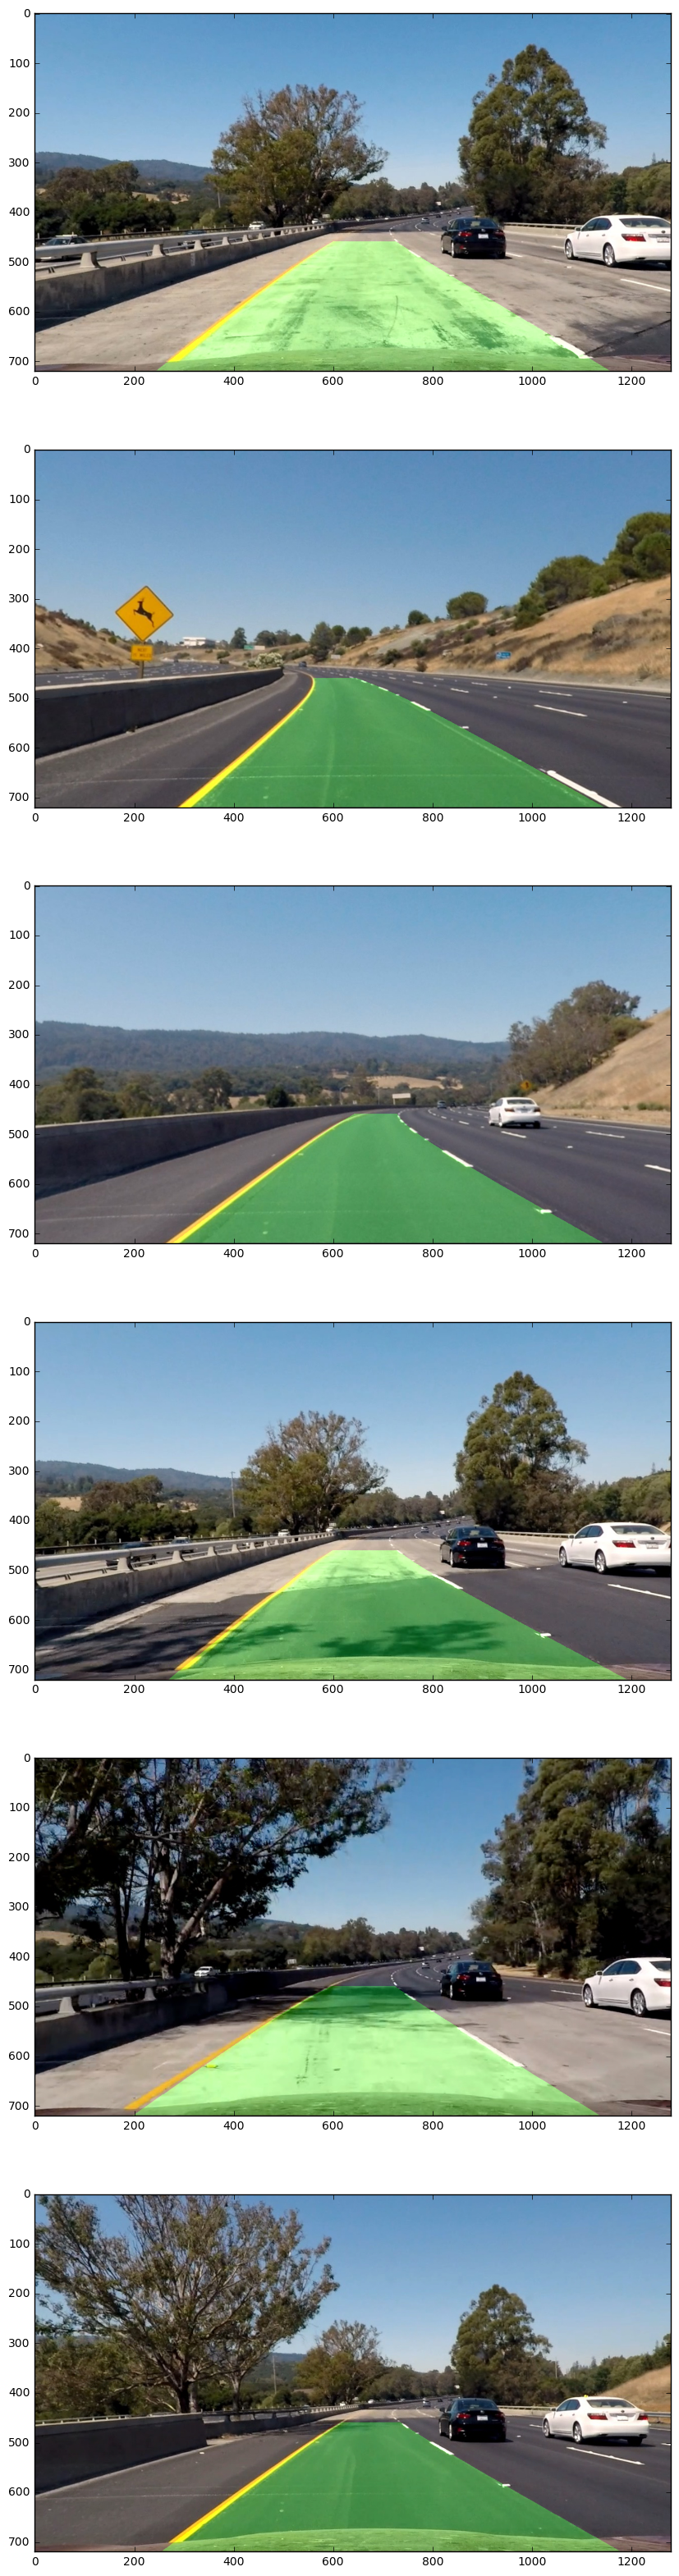

In [9]:
test_images = glob.glob('test_images/test*.jpg')

#fig, axes = plt.subplots(6, 1, figsize=(15,30))
fig, axes = plt.subplots(6, 1, figsize=(10,40))

for i, fname in zip(range(len(test_images)), test_images):
    img = mpimg.imread(fname);
    
    result, left_fit, right_fit, mask, curvature, position = still_image_pipeline(img, mtx, dist)
    
    #axes[i,0].imshow(img)
    #axes[i,0].axis('off')

    axes[i].imshow(result)
    #axes[i,1].axis('off')

    #axes[i,1].plot(left_fit[:,0], left_fit[:,1], 'o', color='red')
    #axes[i,1].plot(right_fit[:,0], right_fit[:,1], 'o', color='blue')
    #axes[i,1].set_xlim(0, 1280)
    #axes[i,1].set_ylim(0, 720)
    #axes[i,1].plot(left_fitx, left_fit[:,1], color='green', linewidth=3)
    #axes[i,1].plot(right_fitx, right_fit[:,1], color='green', linewidth=3)
    #axes[i,1].invert_yaxis() # to visualize as we do the images


    #sname = 'test_images/warped' + str(i) + '.jpg'
    #mpimg.imsave(sname, img2)

plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/test_images_with_lane_overlays.png")

# PLAYGROUND

## Camera Calibration Visualization

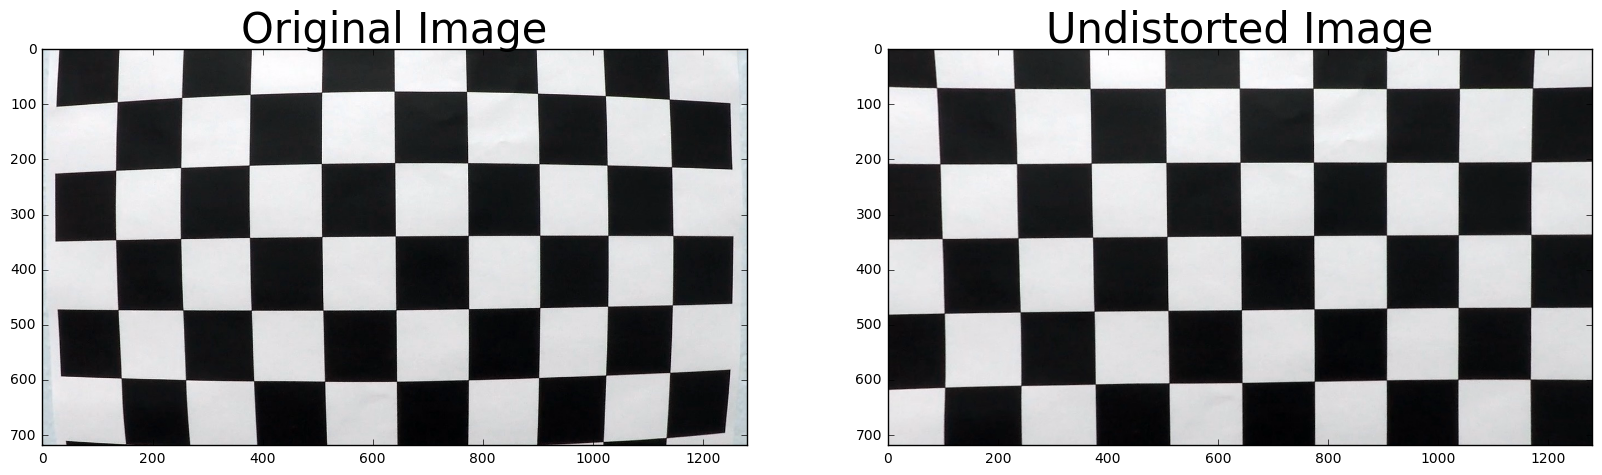

In [9]:
# Visualize undistortion

mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_corrected = correct_distortion(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/calibration.png")

## Distortion Correction Test

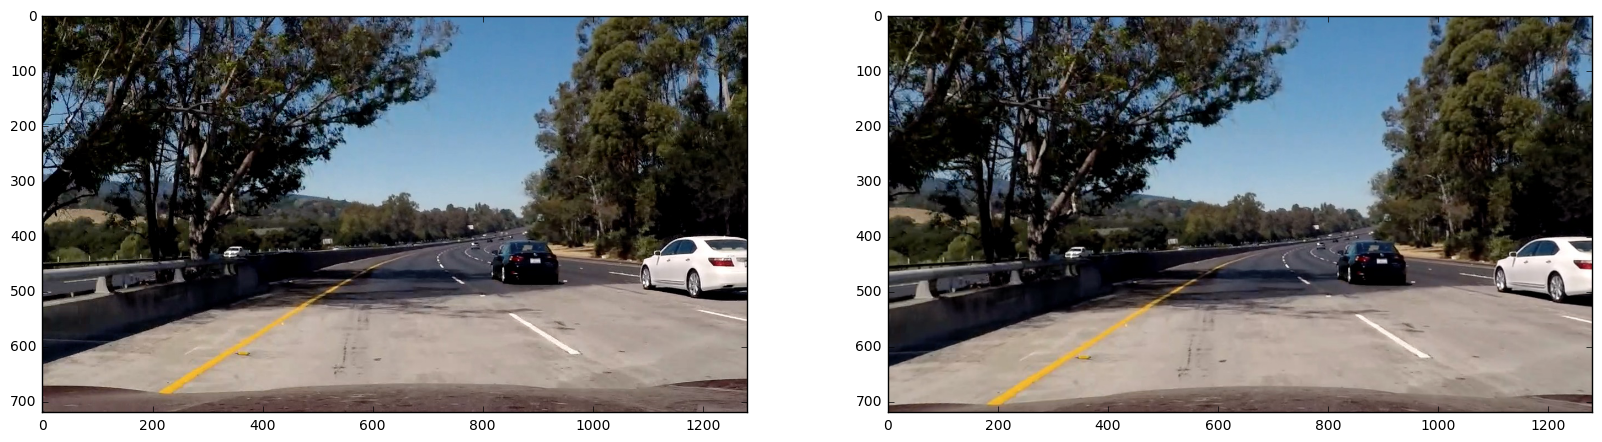

In [97]:
img = mpimg.imread('test_images/test5.jpg')
img2 = correct_distortion(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(img)
ax2.imshow(img2)

plt.show();

#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/correct_distortion.png")

In [ ]:
img = mpimg.imread('test_images/test5.jpg')
img2 = correct_distortion(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(img)
ax2.imshow(img2)

plt.show();

#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/correct_distortion.png")

## Perspective Transformation Test

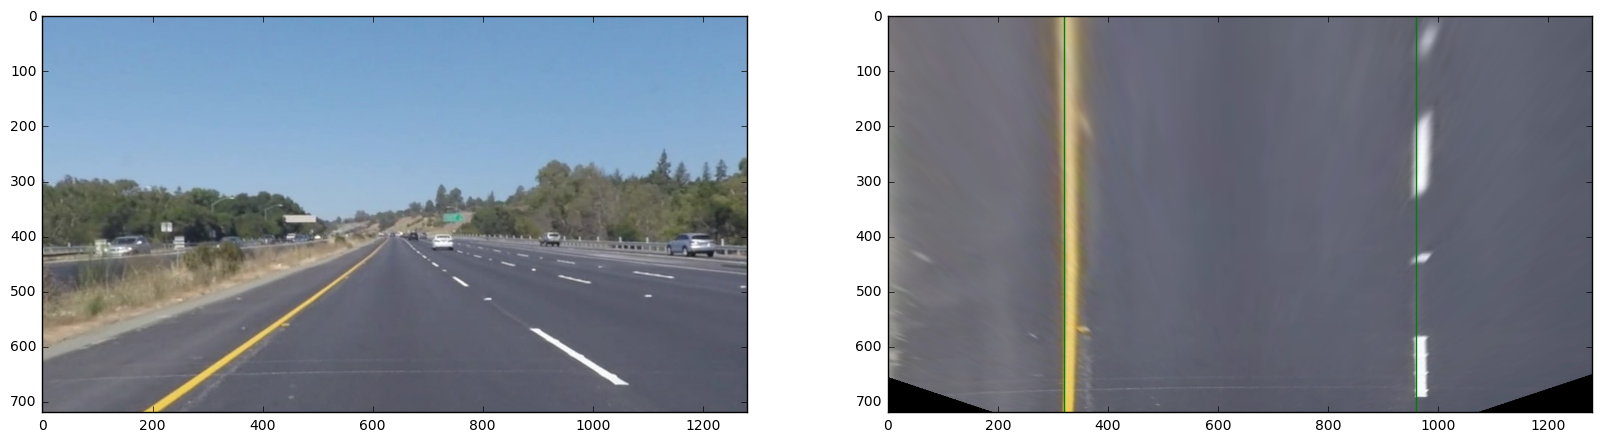

(720, 1280, 3) 960.0


In [162]:
# test perspective transform
def draw_region_of_interest(img, vertices):
    
    #vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

    color = [0,255,0]
    
    left_bottom = (vertices[0][0][0], vertices[0][0][1])
    left_top = (vertices[0][1][0], vertices[0][1][1])
    right_top = (vertices[0][2][0], vertices[0][2][1])
    right_bottom = (vertices[0][3][0], vertices[0][3][1])

    bottom_center = ((right_bottom[0]+left_bottom[0])//2, right_bottom[1])
    top_center = ((right_top[0]+left_top[0])//2, right_top[1])

    
    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)
    #cv2.line(img, bottom_center, top_center, color, 2)
    
img = mpimg.imread('test_images/solidYellowLeft2.jpg')
img = correct_distortion(img, mtx, dist)
shape = img.shape

src = np.float32([
        [shape[1]*.43958, shape[0]*.6389],
        [shape[1]*.14583, shape[0]],
        [shape[1]*.875,   shape[0]],
        [shape[1]*.5625,  shape[0]*.6389]
    ])
dst = np.float32([
        [shape[1]/4,0],
        [shape[1]/4,shape[0]],
        [shape[1]*3/4,shape[0]],
        [shape[1]*3/4,0]
    ])

#src = np.float32([
#    [shape[1]*.457, shape[0]*.6389],
#    [shape[1]*.1586, shape[0]],
#    [shape[1]*.880,  shape[0]],
#    [shape[1]*.543, shape[0]*.6389]
#])
#src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
#dst = np.float32([[320,0],[320,720],[960,720],[960,0]])


M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

rgb = color_threshold(warped, 'R', (190,255)) & color_threshold(warped, 'G', (190,255)) & color_threshold(warped, 'B', (0,155)) 
sobel = abs_sobel_threshold(warped, 'x', 17, (40,180))
saturation = color_threshold(warped, 'L', (200,250))
mask = np.zeros_like(sobel)
mask[(sobel==1) | (saturation==1) | (rgb==1)] = 1

#draw_region_of_interest(img, [[(140,shape[0]),(422,345),(540,345),(840,shape[0])]])
#draw_region_of_interest(img,
#                        [[(np.int(shape[1]*.14583), shape[0]),
#                          (np.int(shape[1]*.43958), np.int(shape[0]*.6389)),
#                          (np.int(shape[1]*.5625),  np.int(shape[0]*.6389)),
#                          (np.int(shape[1]*.875),   shape[0])
#                         ]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

ax1.imshow(img)
ax2.imshow(warped, cmap='gray')
ax2.axvline(shape[1]/4, color='g')
ax2.axvline(shape[1]*3/4, color='g')

plt.show();
print(shape,shape[1]*3/4)
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/perspective_transformation_1.png")

## Lane Line Histogram Test

(273, 309, 290) (908, 945, 927)


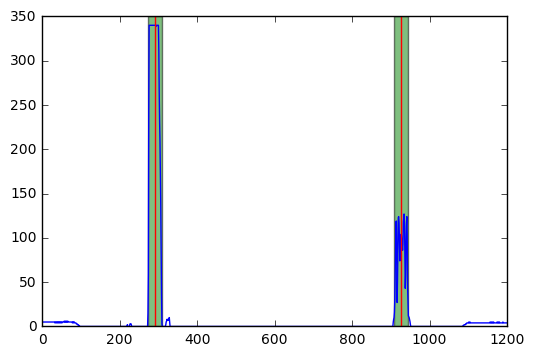

In [163]:

histogram = np.sum(mask[np.int(mask.shape[0]-mask.shape[0]/2):700,40:1240], axis=0)

left_line, right_line = find_line_positions(mask, histogram)
    
print(left_line, right_line)

fig = plt.figure()
plt.plot(histogram)
plt.axvspan(left_line[0], left_line[1], facecolor='g', alpha=0.5)
plt.axvline(left_line[2], color='r')
plt.axvspan(right_line[0], right_line[1], facecolor='g', alpha=0.5)
plt.axvline(right_line[2], color='r')

plt.show()
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/histogram.png")

## Sliding Through Image

[640 637 632 638 637 646 670 663]
[[274 301 288]
 [275 304 289]
 [275 308 291]
 [273 308 291]
 [272 306 289]
 [269 305 285]
 [266 301 279]
 [265 300 279]]
[[912 944 928]
 [910 943 926]
 [866 949 923]
 [906 950 929]
 [906 948 926]
 [909 952 931]
 [902 995 949]
 [921 961 942]]


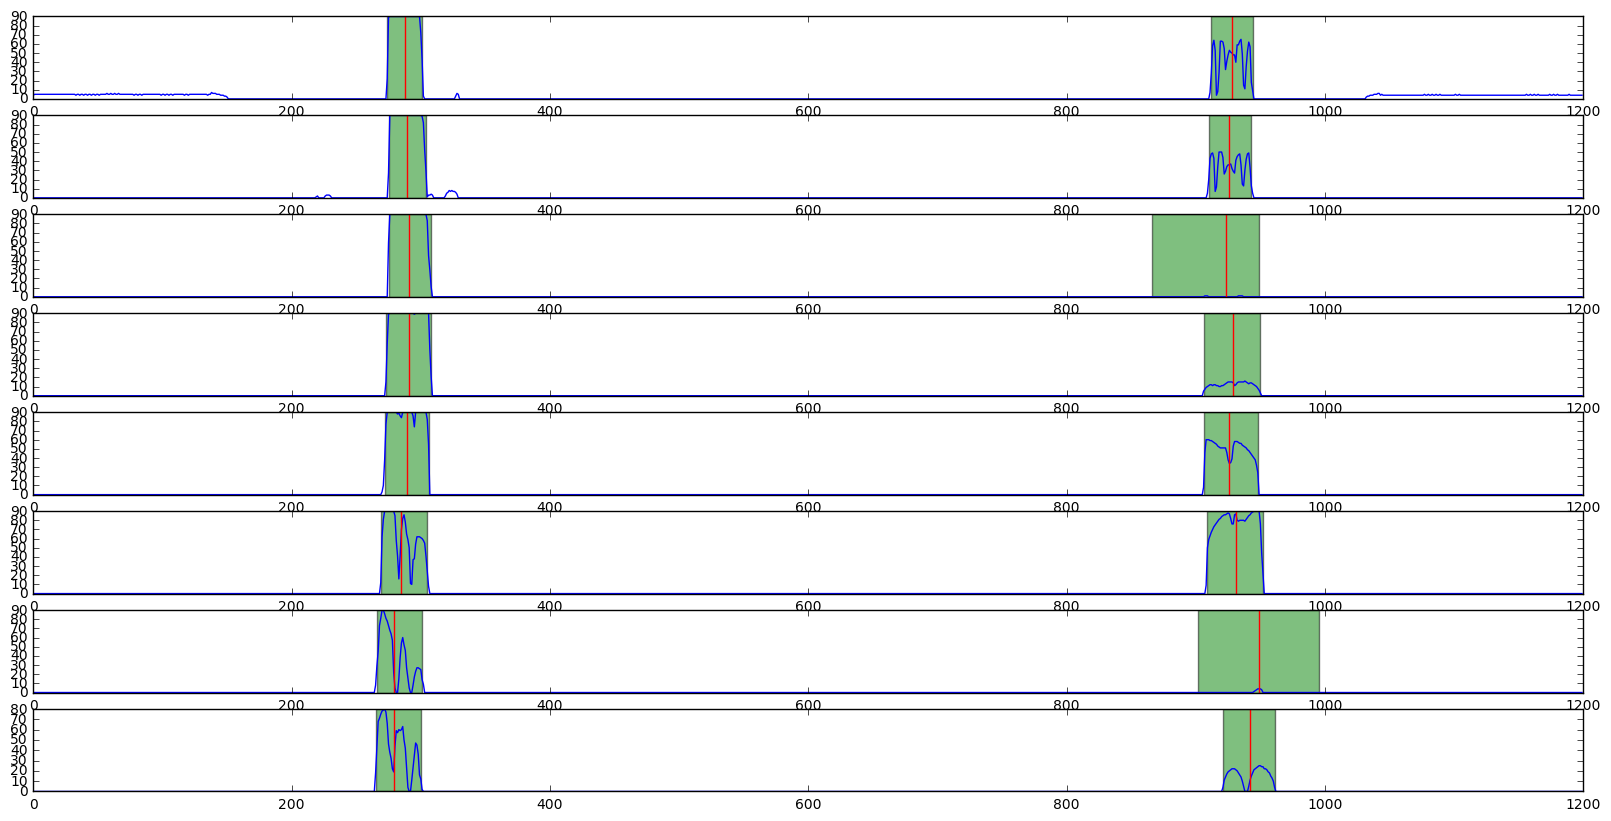

In [164]:

lane = np.array([630,720])
fig, axes = plt.subplots(8, 1, figsize=(20,10))

right_win = np.zeros((8,3),dtype='int')
left_win = np.zeros((8,3),dtype='int')

right_prev = right_line
left_prev = left_line

for i in range(8):
    
    h = np.sum(mask[lane[0]:lane[1],40:1240], axis=0) 
    
    right_win[i] = next_window_position(right_prev, lane, mask[:,40:1240])
    left_win[i] = next_window_position(left_prev, lane, mask[:,40:1240])

    axes[i].plot(h)
    axes[i].axvspan(left_win[i,0], left_win[i,1], facecolor='g', alpha=0.5)
    if left_win[i,2] > 0:
        axes[i].axvline(left_win[i,2], color='r')
    axes[i].axvspan(right_win[i,0], right_win[i,1], facecolor='g', alpha=0.5)
    if right_win[i,2] > 0:
        axes[i].axvline(right_win[i,2], color='r')
    
    right_prev = right_win[i]
    left_prev = left_win[i]
    lane = lane - 90
    
print(right_win[:,2]-left_win[:,2])
print(left_win)
print(right_win)

plt.show()
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/line_finding.png")

## Fitting to Polynomial

[[319  45]
 [319 135]
 [325 225]
 [329 315]
 [331 405]
 [331 495]
 [329 585]
 [328 675]] [[982  45]
 [989 135]
 [971 225]
 [966 315]
 [969 405]
 [963 495]
 [966 585]
 [968 675]]
[[314   0]
 [320  90]
 [324 180]
 [327 270]
 [329 360]
 [330 450]
 [330 540]
 [329 630]
 [327 720]] [[991   0]
 [983  90]
 [976 180]
 [971 270]
 [968 360]
 [966 450]
 [965 540]
 [966 630]
 [969 720]]


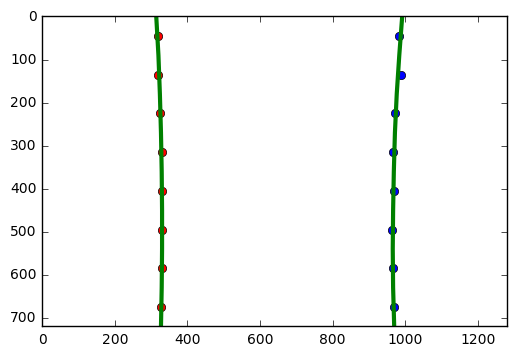

In [169]:
# Determine the curvature of the lane and vehicle position with respect to center.
left_fit = get_fit_data(left_win)
right_fit = get_fit_data(right_win)

# correct x-offset 
left_fit[:,0] = left_fit[:,0] + 40
right_fit[:,0] = right_fit[:,0] + 40

#print(left_fit, right_fit)

fig = plt.figure()

plt.plot(left_fit[:,0], left_fit[:,1], 'o', color='red')
plt.plot(right_fit[:,0], right_fit[:,1], 'o', color='blue')

yvals=np.array([0,90,180,270,360,450,540,630,720])

left_points, left_coef = do_polyfit(left_fit, yvals)
right_points, right_coef = do_polyfit(right_fit, yvals)

#print(left_points, right_points)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_points[:,0], left_points[:,1], color='green', linewidth=3)
plt.plot(right_points[:,0], right_points[:,1], color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/polyfit.png")

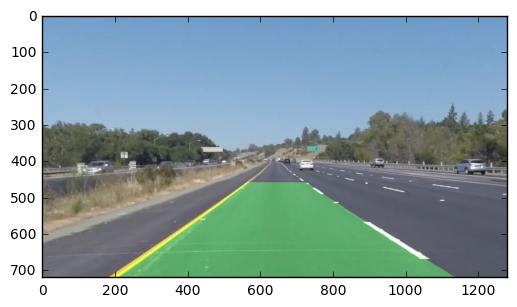

In [170]:
# Warp the detected lane boundaries back onto the original image.
overlay = make_lane_overlay(mask, left_points, right_points, src, dst)
    
result = cv2.addWeighted(img, 1, overlay, 0.3, 0)
plt.imshow(result);

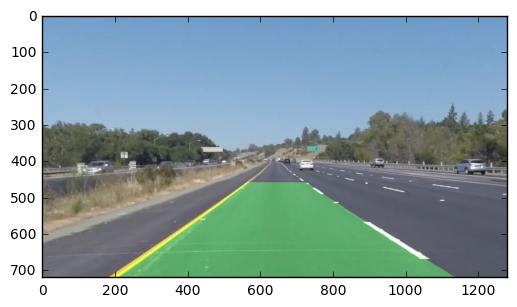

In [171]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(mask).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_points[:,0], left_points[:,1]]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_points[:,0], right_points[:,1]])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

plt.imshow(color_warp)

#src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
#dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
      
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result);

## Threshold Experimenting

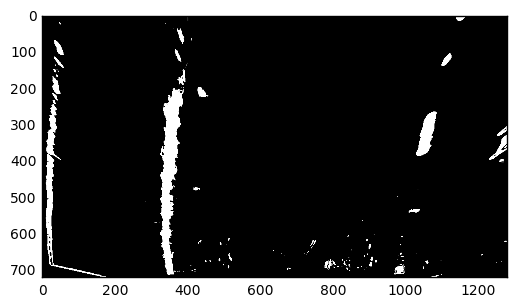

In [93]:
# test gradient combinations

from ipywidgets import widgets

def plt_gradx(sobel_mn, sobel_mx, ksize, color_mn, color_mx):
    rgb = color_threshold(img, 'R', (190,255)) & color_threshold(img, 'G', (190,255)) & color_threshold(img, 'B', (0,155)) 
    gradx = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=(sobel_mn,sobel_mx))
    col = color_threshold(img, 'L', (color_mn,color_mx))
    mask = np.zeros_like(col)
    mask[((col==1) | (gradx==1) | (rgb==1))] = 1
    #mask[(rgb==1)] = 1
    f, ax = plt.subplots(1,1)
    ax.imshow(mask,cmap='gray');

img = mpimg.imread('test_images/warped0.jpg')
                                                 
widgets.interact(plt_gradx, sobel_mn=(0,255,1), sobel_mx=(0,255,1), ksize=(3,31,2), color_mn=(0,255), color_mx=(0,255))    

## Colorspace Exploring

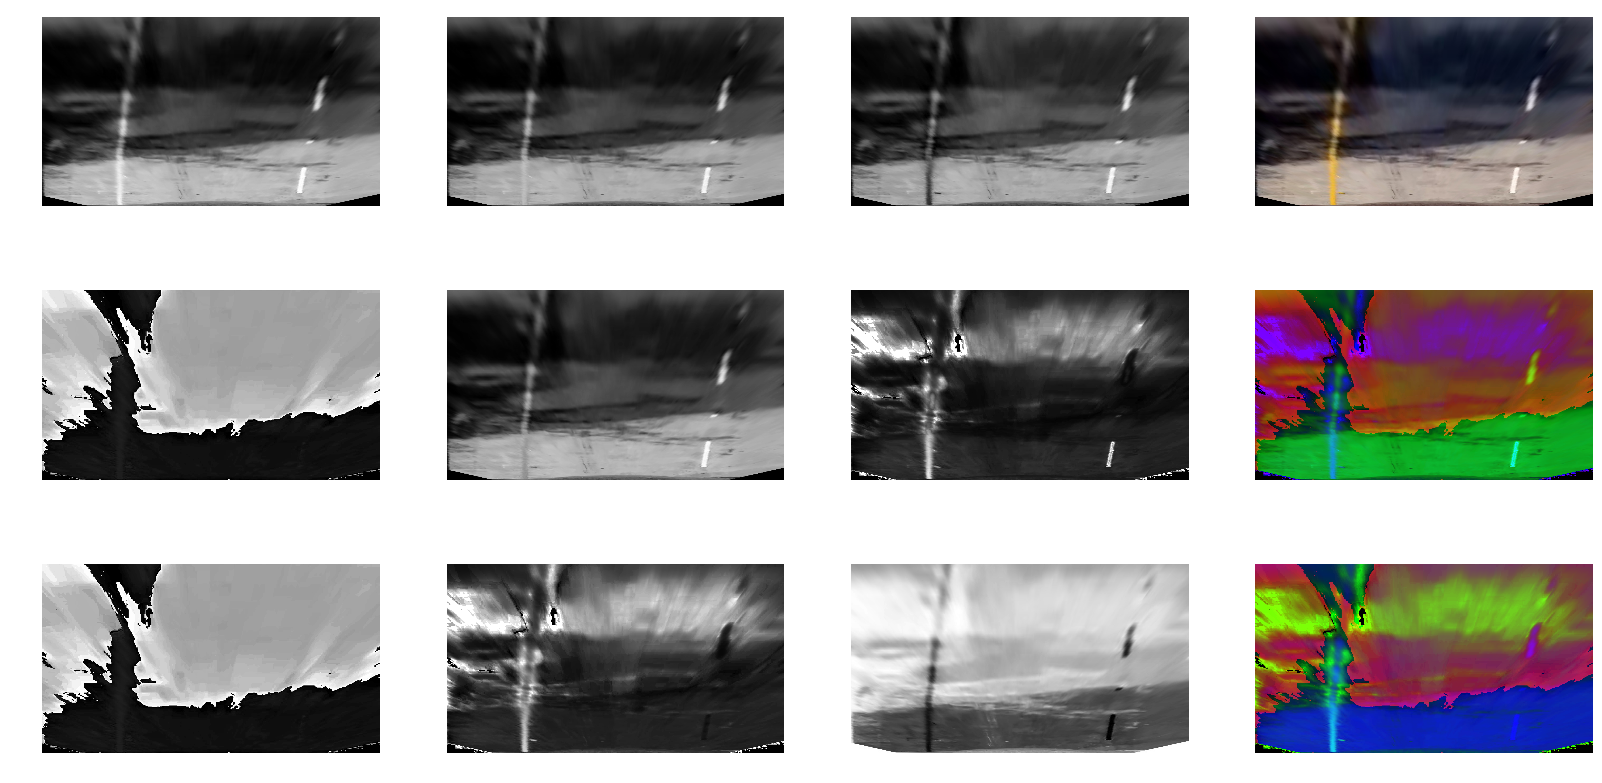

In [203]:
img = mpimg.imread('test_images/warped4.jpg')
fig, axes = plt.subplots(3, 4, figsize=(20,10))

axes[0,0].imshow(img[:,:,0], cmap='gray')
axes[0,0].axis('off')
axes[0,1].imshow(img[:,:,1], cmap='gray')
axes[0,1].axis('off')
axes[0,2].imshow(img[:,:,2], cmap='gray')
axes[0,2].axis('off')
axes[0,3].imshow(img)
axes[0,3].axis('off')

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
axes[1,0].imshow(hls[:,:,0], cmap='gray')
axes[1,0].axis('off')
axes[1,1].imshow(hls[:,:,1], cmap='gray')
axes[1,1].axis('off')
axes[1,2].imshow(hls[:,:,2], cmap='gray')
axes[1,2].axis('off')
axes[1,3].imshow(hls)
axes[1,3].axis('off')

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#hsv[:,:,1] = cv2.equalizeHist(img[:,:,1])
axes[2,0].imshow(hsv[:,:,0], cmap='gray')
axes[2,0].axis('off')
axes[2,1].imshow(hsv[:,:,1], cmap='gray')
axes[2,1].axis('off')
axes[2,2].imshow(255 - hsv[:,:,2], cmap='gray')
axes[2,2].axis('off')
axes[2,3].imshow(hsv, cmap='hsv')
axes[2,3].axis('off')

plt.show()

In [ ]:
- No lane peaks from histogram:
  * first frame : skip frame
  * other frame:  get previous good frame / count bad frame data PER LANE

- One or more peaks are missing: (almost same as above)
   * first frame : not applicable because we cannot compare with previous state
   * other frame : 
             a) increase the count for bad frames for the current lane 
             b) if we have reached a critical count (say 10 lost frames) we search again for peaks. if it is still missing we stop drawing that lane
             c) if not we bring the lane polynomial from the previous frame and check if it is compatible with the other lanes (discuss that below)

- One or more peaks is found but has curvature that is out of bounds or much different from the other lanes:
    a) we can either pick from the previous good frame (if there is one)
     or b) copy from the other lanes by offsetting the curve
    It is also important which lane is it. As we go to the right , its less important (if we monitor more than one lane)


- Check the first two lanes if they are still parallel (in the bottom of the image).
    If the lanes open up (i think we go uphil) and we need to devise an algorithm to change perceptive to make them again parallel 

so in general
  a) copy from previous frame
  b) copy from other lanes
  c) if exceeds number of bad frames search the histogram again and if it fails drop the lane
  d) check for perspective changes

First quantity (ensure i have data, if not get from past frame), then quality (ensure they are compatible, first with each other then with previous frame)